In [4]:
import pandas as pd
import torch
import os

In [17]:
train_df = pd.read_csv("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/train_inductive.csv")
val_df   = pd.read_csv("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/val_inductive.csv")
test_df  = pd.read_csv("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/test_inductive.csv")


In [18]:
# Build entity & relation vocab from TRAIN ONLY

entities = sorted(set(train_df["head"]).union(set(train_df["tail"])))
relations = sorted(set(train_df["relation"]))

ent2id = {e: i for i, e in enumerate(entities)}
rel2id = {r: i for i, r in enumerate(relations)}

print(f"Entities in train: {len(ent2id)}")
print(f"Relations in train: {len(rel2id)}")

Entities in train: 94046
Relations in train: 107


In [19]:
# Convert train triples to tensor

src = [ent2id[h] for h in train_df["head"]]
dst = [ent2id[t] for t in train_df["tail"]]
etype = [rel2id[r] for r in train_df["relation"]]

edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_type = torch.tensor(etype, dtype=torch.long)

print("Train graph:", edge_index.shape, edge_type.shape)


Train graph: torch.Size([2, 5261827]) torch.Size([5261827])


In [20]:
# Map val/test triples

def map_triples(df, ent2id, rel2id):
    mapped = []
    for _, row in df.iterrows():
        if row["head"] in ent2id and row["tail"] in ent2id and row["relation"] in rel2id:
            mapped.append([ent2id[row["head"]], rel2id[row["relation"]], ent2id[row["tail"]]])
    return torch.tensor(mapped, dtype=torch.long)

val_triples = map_triples(val_df, ent2id, rel2id)
test_triples = map_triples(test_df, ent2id, rel2id)

print("Validation triples mapped:", val_triples.shape)
print("Test triples mapped:", test_triples.shape)

Validation triples mapped: torch.Size([582709, 3])
Test triples mapped: torch.Size([4855, 3])


In [ ]:
# Save for training
torch.save(edge_index, "C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/edge_index.pt")
torch.save(edge_type, "C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/edge_type.pt")
torch.save(val_triples, "C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/val_triples.pt")
torch.save(test_triples, "C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/test_triples.pt")


In [23]:

with open("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/entities.txt", "w") as f:
    for e, i in ent2id.items():
        f.write(f"{i}\t{e}\n")

with open("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/relations.txt", "w") as f:
    for r, i in rel2id.items():
        f.write(f"{i}\t{r}\n")

print("Graph construction complete. Ready for GNN modeling!")

Graph construction complete. Ready for GNN modeling!


#Visualization of Graph of ~ 30 nodes

In [39]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


In [29]:
#Loading of vocab mapping and graph edges

ent_id2name = {}
with open("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/entities.txt") as f:
    for line in f:
        idx, ent = line.strip().split("\t")
        ent_id2name[int(idx)] = ent

rel_id2name = {}
with open("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/relations.txt") as f:
    for line in f:
        idx, rel = line.strip().split("\t")
        rel_id2name[int(idx)] = rel

edge_index = torch.load("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/edge_index.pt")
edge_type = torch.load("C:/Users/Manasa/OneDrive/Desktop/Drug_Repurposing_Gnn/Drug_Repurposing_Gnn/data/processed_graph/edge_type.pt")


In [45]:

# Converting tensors to numpy
src_nodes = edge_index[0].numpy()
dst_nodes = edge_index[1].numpy()
rel_types = edge_type.numpy()

#  Building a  NetworkX graph

G = nx.DiGraph()
for s, d, r in zip(src_nodes, dst_nodes, rel_types):
    G.add_edge(ent_id2name[s], ent_id2name[d], relation=rel_id2name[r])

print(f"Total nodes: {len(G.nodes())}, Total edges: {len(G.edges())}")


# Taking a sample of 40 nodes for visualization 

sample_nodes = list(G.nodes())[:50]  
H = G.subgraph(sample_nodes).copy()


Total nodes: 94046, Total edges: 4512253


In [52]:
# Coloring the nodes by type 
def get_color(node):
    if "DrugBank" in node:
        return "#e41a1c"   # bright red
    elif "Gene" in node or "Protein" in node:
        return "#377eb8"   # vivid blue
    elif "Disease" in node or "DOID" in node:
        return "#4daf4a"   # green
    else:
        return "gray"

colors = [get_color(n) for n in H.nodes()]

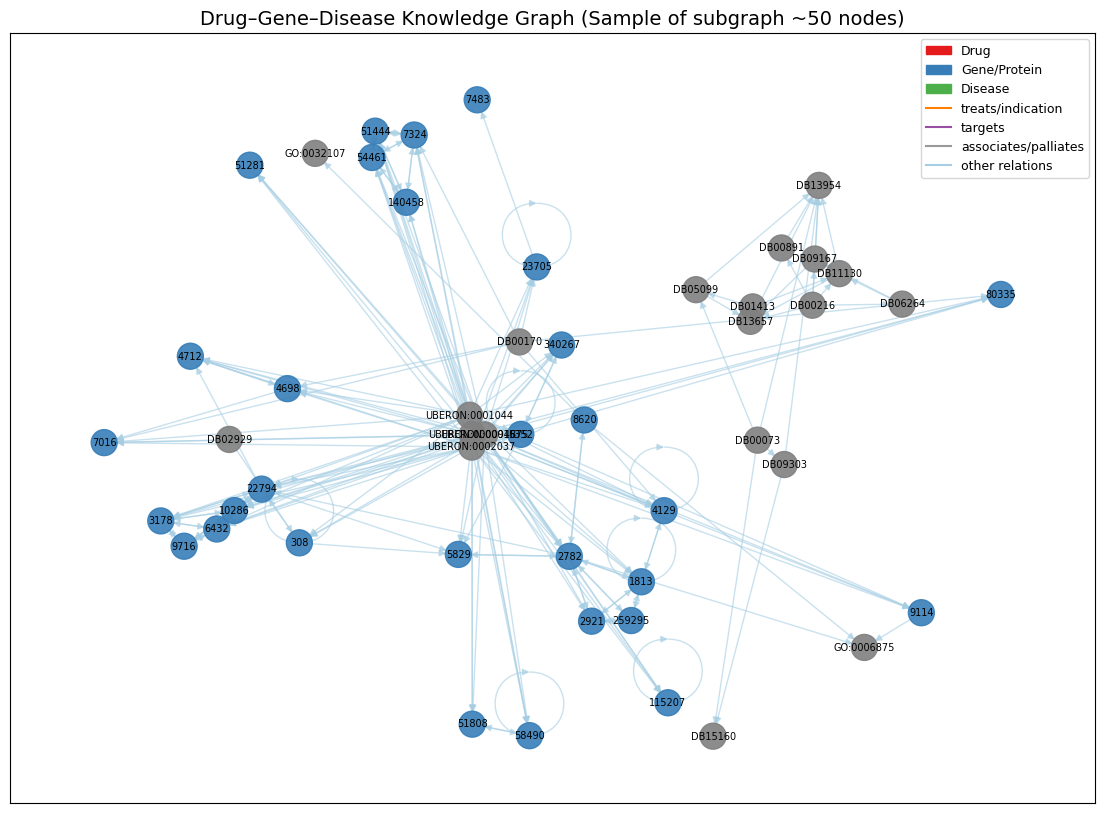

In [54]:
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(H, k=0.35, seed=42)

# Draw nodes
nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=350, alpha=0.9)

# Draw edges one relation type at a time
for rel_type, color in [
    ("treat", "#ff7f00"),       
    ("indication", "#ff7f00"), 
    ("target", "#984ea3"),      
    ("associate", "#999999"),   
    ("palliate", "#999999"),    
]:
    rel_edges = [(u, v) for u, v, d in H.edges(data=True) if rel_type in d["relation"].lower()]
    nx.draw_networkx_edges(H, pos, edgelist=rel_edges, edge_color=color, alpha=0.6, arrows=True)

# Draw all "other" edges in light blue
other_edges = [(u, v) for u, v, d in H.edges(data=True)
               if not any(k in d["relation"].lower() for k in ["treat", "indication", "target", "associate", "palliate"])]
nx.draw_networkx_edges(H, pos, edgelist=other_edges, edge_color="#a6cee3", alpha=0.6, arrows=True)

# Draw labels
nx.draw_networkx_labels(H, pos, {n: n.split("::")[-1] for n in H.nodes()}, font_size=7)

# Legend
drug_patch = mpatches.Patch(color="#e41a1c", label="Drug")
gene_patch = mpatches.Patch(color="#377eb8", label="Gene/Protein")
disease_patch = mpatches.Patch(color="#4daf4a", label="Disease")

treat_line = mlines.Line2D([], [], color="#ff7f00", label="treats/indication")
target_line = mlines.Line2D([], [], color="#984ea3", label="targets")
assoc_line = mlines.Line2D([], [], color="#999999", label="associates/palliates")
other_line = mlines.Line2D([], [], color="#a6cee3", label="other relations")

plt.legend(handles=[drug_patch, gene_patch, disease_patch, 
                    treat_line, target_line, assoc_line, other_line],
           loc="upper right", fontsize=9, frameon=True)

plt.title("Drug–Gene–Disease Knowledge Graph (Sample of subgraph ~50 nodes)", fontsize=14)
plt.show()


In [55]:
# Exporting to Gephi
nx.write_gexf(H, "subgraph_for_gephi.gexf")
print("Subgraph saved as 'subgraph_for_gephi.gexf' for visualization in Gephi.")


Subgraph saved as 'subgraph_for_gephi.gexf' for visualization in Gephi.
